In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split


# Ścieżki do katalogów z danymi
paths = [
    "chest_xray/train/NORMAL", "chest_xray/train/PNEUMONIA",
    "chest_xray/test/NORMAL", "chest_xray/test/PNEUMONIA",
    "chest_xray/val/NORMAL", "chest_xray/val/PNEUMONIA"
]

list_total = []

for path in paths:
    # Ustalenie etykiety na podstawie nazwy katalogu
    label = 0 if "NORMAL" in path else 1
    # Przejście przez wszystkie pliki w danym katalogu
    for img in os.listdir(path):
        # Pełna ścieżka do pliku
        full_path = os.path.join(path, img)
        # Dodanie ścieżki i etykiety do listy
        list_total.append([full_path, label])

# Przykładowe wyświetlenie pierwszych 5 elementów listy
print(list_total[:5])

[['chest_xray/train/NORMAL\\IM-0115-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0117-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0119-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0122-0001.jpeg', 0], ['chest_xray/train/NORMAL\\IM-0125-0001.jpeg', 0]]


In [2]:
# Tworzymy DataFrame
df_total = pd.DataFrame(list_total, columns=['image', 'label'])

# Mieszamy dane
df_total = df_total.sample(frac=1)

# Dzielimy na podzbiory
X_total = df_total['image']
y_total = df_total['label']

X_train, X_temp, y_train, y_temp = train_test_split(X_total, y_total, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f'Liczebność zbioru treningowego: {len(X_train)}')
print(f'Liczebność zbioru testowego: {len(X_test)}')
print(f'Liczebność zbioru walidacyjnego: {len(X_val)}')

Liczebność zbioru treningowego: 4099
Liczebność zbioru testowego: 879
Liczebność zbioru walidacyjnego: 878


In [3]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definicja generatora augmentacji danych
data_gen = ImageDataGenerator(
    rotation_range=10,  # rotacja do 10 stopni
    width_shift_range=0.1,  # przesunięcie w osi X do 10% szerokości
    height_shift_range=0.1,  # przesunięcie w osi Y do 10% wysokości
    shear_range=0.1,  # ścinanie do 10%
    zoom_range=0.1,  # przybliżenie do 10%
    horizontal_flip=True,  # odwrócenie w poziomie (jak w lustrze)
    fill_mode='nearest',  # tryb wypełniania brakujących pikseli
    brightness_range=[0.8,1.2],  # zakres zmian jasności
)


def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, (256, 256, 1))
    img = data_gen.random_transform(img)
    
    return img

def compose_dataset(X, y):
    data = []
    labels = []
    
    for img_path, label in zip(X, y):
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

# Przygotowanie danych
X_train, y_train = compose_dataset(X_train, y_train)
X_test, y_test = compose_dataset(X_test, y_test)
X_val, y_val = compose_dataset(X_val, y_val)

Typ X_val: <class 'numpy.ndarray'>
Typ y_val: <class 'numpy.ndarray'>
Kształt X_val: (878, 256, 256, 1)
Kształt y_val: (878,)
Maksymalny indeks w y_val: 1
Rozmiar X_val: 878
Pierwsze 5 etykiet w y_val: [1 0 0 1 1]
Pierwszy obraz w X_val: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
Zbalansowanie klas w y_val: {0: 245, 1: 633}
(4099, 2)
(490, 2)


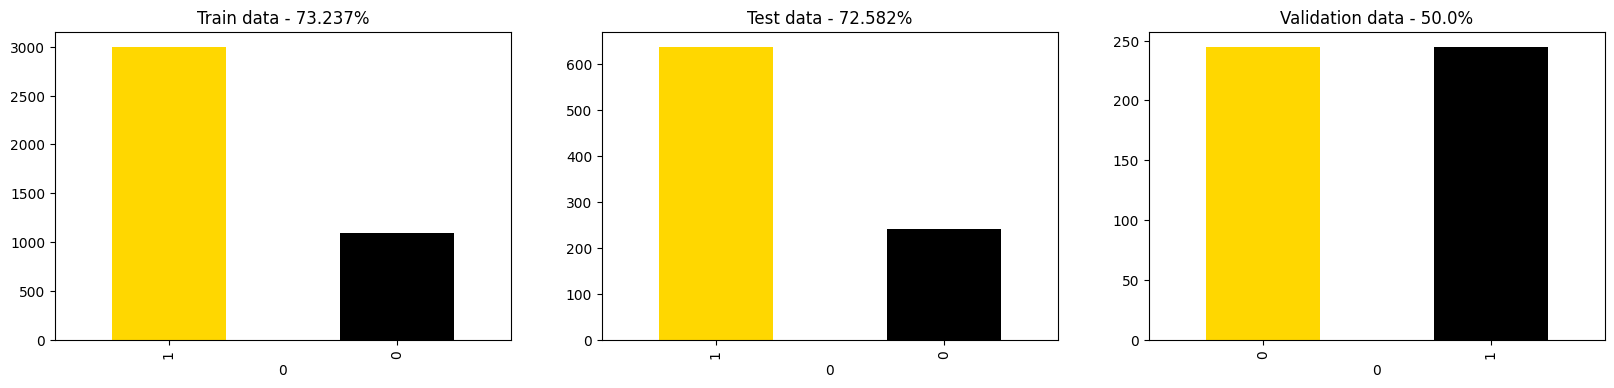

In [4]:
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import shuffle


# Sprawdź typy danych
print(f"Typ X_val: {type(X_val)}")
print(f"Typ y_val: {type(y_val)}")

# Sprawdź kształt tablic
print(f"Kształt X_val: {X_val.shape}")
print(f"Kształt y_val: {y_val.shape}")

# Zakładając, że y_val zawiera etykiety jako pojedynczą kolumnę
# Sprawdź zakres indeksów
print(f"Maksymalny indeks w y_val: {y_val.max()}")
print(f"Rozmiar X_val: {X_val.shape[0]}")

# Upewnij się, że zakres indeksów jest poprawny
assert y_val.max() < X_val.shape[0], "Indeks jest poza zakresem!"

# Sprawdź zawartość tablic
print("Pierwsze 5 etykiet w y_val:", y_val[:5])
print("Pierwszy obraz w X_val:", X_val[0])

# Sprawdź zbalansowanie klas
unique, counts = np.unique(y_val, return_counts=True)
print("Zbalansowanie klas w y_val:", dict(zip(unique, counts)))


def balance_validation_set(X, y):
    # Znajdź indeksy dla każdej klasy
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    # Upewnij się, że nie próbujesz wybrać więcej przykładów niż istnieje
    n_samples = min(len(class_0_indices), len(class_1_indices))
    
    # Zbalansuj klasy
    np.random.seed(0) # Ustaw seed dla powtarzalności
    class_0_indices_balanced = np.random.choice(class_0_indices, size=n_samples, replace=False)
    class_1_indices_balanced = np.random.choice(class_1_indices, size=n_samples, replace=False)
    
    # Połącz indeksy i przetasuj
    balanced_indices = np.concatenate((class_0_indices_balanced, class_1_indices_balanced))
    balanced_indices = shuffle(balanced_indices, random_state=0)
    
    # Zastosuj indeksy do X i y
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

# Użyj funkcji do zbalansowania zbioru walidacyjnego
X_val_balanced, y_val_balanced = balance_validation_set(X_val, y_val)

#Konwersja etykiet na format kategoryczny
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val_balanced = to_categorical(y_val_balanced)
print(y_train.shape)
print(y_val_balanced.shape)

import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))

# Wykres dla zbioru treningowego
# Wykres dla zbioru treningowego
plt.subplot(1,3,1)
pd.DataFrame(y_train.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1 = 100 * np.sum(y_train[:, 1]) / len(y_train)
plt.title(f'Train data - {round(percentage_of_class_1, 3)}%')

# Wykres dla zbioru testowego
plt.subplot(1,3,2)
pd.DataFrame(y_test.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1_test = 100 * np.sum(y_test[:, 1]) / len(y_test)
plt.title(f'Test data - {round(percentage_of_class_1_test, 3)}%')

# Wykres dla zbioru walidacyjnego
plt.subplot(1,3,3)
pd.DataFrame(y_val_balanced.argmax(axis=1))[0].value_counts().plot(kind='bar', color=['gold','black'])
percentage_of_class_1_val = 100 * np.sum(y_val_balanced[:, 1]) / len(y_val_balanced)
plt.title(f'Validation data - {round(percentage_of_class_1_val, 3)}%')
plt.show()

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Konfiguracja TensorFlow do korzystania z GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

# Wczytanie modelu ResNet50 z wagami wytrenowanymi na ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Zamrożenie wag modelu bazowego
for layer in base_model.layers:
    layer.trainable = False

# Budowa modelu funkcjonalnego
input_layer = Input(shape=(256, 256, 1))
x = Concatenate()([input_layer, input_layer, input_layer])  # Konwersja do 3 kanałów
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definicja wczesnego zatrzymywania i zapisu najlepszego modelu
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Podsumowanie modelu
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_7[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │  1,049,088 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     65,664 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2)         │        258 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,702,722 (94.23 MB)

 Trainable params: 1,115,010 (4.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# Trenowanie modelu
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val_balanced, y_val_balanced),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50


c:\Users\pklyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.6810 - loss: 0.7424 - val_accuracy: 0.5000 - val_loss: 0.7521
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7277 - loss: 0.6106 - val_accuracy: 0.5000 - val_loss: 0.7625
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7344 - loss: 0.5968 - val_accuracy: 0.5000 - val_loss: 0.7664
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7235 - loss: 0.6027 - val_accuracy: 0.5000 - val_loss: 0.7550
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.7423 - loss: 0.5845 - val_accuracy: 0.5000 - val_loss: 0.7327
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7396 - loss: 0.5836 - val_accuracy: 0.5000 - val_loss: 0.7485
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.7315 - loss: 0.5870 - val_accuracy: 0.5000 - val_loss: 0.7919
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.7329 - loss: 0.5814 - val_accuracy: 0.500